In [1]:
%matplotlib inline
import zipfile as zf
import pandas as pd
import spacy

nlp = spacy.load('en')
corpus = zf.ZipFile('cases 1000 smallest.zip')

lFileName = [docInfo.filename for docInfo in corpus.infolist()
             if (docInfo.filename.endswith('.txt') and not docInfo.filename.startswith('__MACOSX'))]

docs = [nlp(corpus.open(fileName).read().decode('unicode_escape').lower()) for fileName in lFileName]

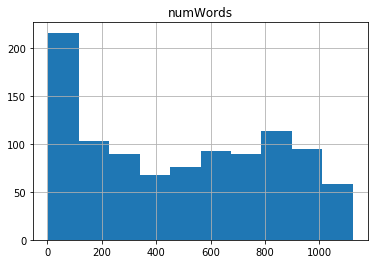

In [2]:
numSentences = [len(list(doc.sents)) for doc in docs]
numWords = [len([token for token in doc if (token.pos_ not in {'PUNCT', 'SPACE'})]) for doc in docs]
numLetters = [len([token.text for token in doc if (token.pos_ not in {'PUNCT', 'SPACE'})]) for doc in docs]
dataDf = pd.DataFrame({'numSentences': numSentences, 'numWords': numWords, 'numLetters': numLetters})

dataDf.hist('numSentences')
dataDf.hist('numWords')
dataDf.hist('numLetters')

del numSentences, numWords, numLetters, dataDf

In [3]:
year = [int(fileName[fileName.find('/')+1:fileName.find('_')]) for fileName in lFileName]

freqNoun = [(len([token for token in doc if token.pos_ == 'NOUN']) /
            len([token for token in doc if token.pos_ not in {'PUNCT', 'SPACE'}])) for doc in docs]

freqAdj = [(len([token for token in doc if token.pos_ == 'ADJ']) /
            len([token for token in doc if token.pos_ not in {'PUNCT', 'SPACE'}])) for doc in docs]

freqVerb = [(len([token for token in doc if token.pos_ == 'VERB']) /
            len([token for token in doc if token.pos_ not in {'PUNCT', 'SPACE'}])) for doc in docs]

data2Df = pd.DataFrame({'year': year, 'freqNoun': freqNoun, 'freqAdj': freqAdj, 'freqVerb': freqVerb})
data2Df.groupby('year')[['freqNoun', 'freqAdj', 'freqVerb']].mean().plot()

del year, freqNoun, freqAdj, freqVerb, data2Df

In [4]:
from collections import Counter
from nltk import ngrams
from functools import reduce
from operator import mul

wordFreqs = Counter()

# the words are filtered first filtered for punctuations and spaces by POS tag from spacy
# and stop words are ignored, to filter out as much noise as possible considering a small feature set.

for doc in docs:
    for token in doc:
        if (token.pos_ not in {'PUNCT', 'SPACE'} and not token.is_stop):
            wordFreqs[token.lemma_] += 1
    
    
trigramFreqs = Counter()

for doc in docs:
    doc.user_data = Counter()
    for trigram in list(ngrams([(token.lemma_, token.pos_) for token in doc
                                if (token.pos_ not in {'PUNCT', 'SPACE'} and not token.is_stop)],3)):
        if list(trigram)[2][1] == 'NOUN':
            trigramFreqs['_'.join([x[0] for x in trigram])] += 1
            doc.user_data['_'.join([x[0] for x in trigram])] += 1

trigramFreqsLimited = [x for x in trigramFreqs.most_common(1000)]
        
def get_gmean(trigram, trigramDocFreqs):
    words = trigram[0].split('_')
    n = len(words)
    p = [wordFreqs[w]**(1/n) for w in words]
    trigramName = '_'.join([x for x in words])
    num = trigramDocFreqs[trigramName]
    den = reduce(mul, p)
    if den == 0:
        return 0.0
    gmean = num / den
    return gmean


topFeatureSetDf = pd.DataFrame({'trigram': [trigram[0] for trigram in trigramFreqsLimited], 
                             'count': [trigram[1] for trigram in trigramFreqsLimited], 
                             'gmean': [get_gmean(trigram, trigramFreqs) for trigram in trigramFreqsLimited]})


display(topFeatureSetDf.sort_values('gmean'))

del topFeatureSetDf, trigramFreqs

trigram  count     gmean
680                court_state_court      5  0.001170
585             district_court_court      6  0.001653
987                 file_state_court      4  0.001770
437                 case_state_court      6  0.001858
913                 suit_state_court      4  0.001980
978         jurisdiction_state_court      4  0.001991
738                state_claim_court      5  0.002014
964               case_federal_court      4  0.002134
827              state_circuit_court      5  0.002171
858          district_court_judgment      5  0.002233
969                   court_'s_grant      4  0.002266
609              state_federal_court      5  0.002281
647           united_state_appellant      5  0.002348
914           case_judgment_district      4  0.002363
763         defendant_district_court      5  0.002381
981                file_united_state      4  0.002393
409               state_court_appeal      7  0.002414
855                 state_court_suit      5  0.002475
625          district_court_decision      5  0.002532
762              deny_district_court      5  0.002555
853           state_court_proceeding      5  0.002598
810                 case_trial_court      5  0.002602
538                  state_tax_court      6  0.002621
654                 1_district_court      5  0.002656
918               court_reverse_case      4  0.002673
920                case_decide_court      4  0.002715
505              federal_court_state      6  0.002737
188             court_district_court     10  0.002755
578              supreme_court_court      6  0.002766
813               court_affirm_order      5  0.002801
..                               ...    ...       ...
139       selective_training_service     12  0.164149
12              labor_relation_board     54  0.167933
219                   new_south_wale     10  0.168682
693                joseph_e._swanson      5  0.180772
803        cure_mitigation_treatment      5  0.182632
594    pattern_racketeering_activity      6  0.192054
715         hunting_fish_reservation      5  0.192689
407        cash_receipt_disbursement      7  0.195737
0                    v._united_state    573  0.204151
264                         11_sub_e      9  0.204493
796                    cong_1st_sess      5  0.205518
941                burton_sutton_oil      4  0.225250
45   collective_bargaining_agreement     23  0.226253
13     commissioner_internal_revenue     54  0.228652
25             unfair_labor_practice     30  0.233238
327    brotherhood_railroad_trainman      8  0.234865
17             internal_revenue_code     41  0.253687
182              average_weekly_wage     11  0.269372
317  bluffton_electrical_association      8  0.282624
506                 cent_square_foot      6  0.287179
193                     cong_2d_sess     10  0.326239
607               dixie_pine_product      6  0.333333
6            national_labor_relation     89  0.383646
98      privilege_self_incrimination     16  0.387572
9                  writ_habea_corpus     63  0.408095
26                    rehear_en_banc     30  0.415646
1                           c._c._a.    183  0.418234
449                    mrs_le_gierse      6  0.480750
518                   big_horn_river      6  0.492061
132         cruel_unusual_punishment     13  0.535589

[1000 rows x 3 columns]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

gmean = [[get_gmean(trigram, doc.user_data) for trigram in trigramFreqsLimited] for doc in docs]

featureSetDf = pd.DataFrame({'caseID': [str(fileName[fileName.find('_')+1:fileName.find('.')]) for fileName in lFileName],
                             'gmean': [[get_gmean(trigram, doc.user_data) for trigram in trigramFreqsLimited] for doc in docs]})

caseReversedDf = pd.read_csv('case_reversed.csv')

featureSetDf = pd.merge(featureSetDf, caseReversedDf, left_on='caseID', right_on='caseid')

trainDf, testDf = train_test_split(featureSetDf, test_size=0.2)

XTrain = [gmean for gmean in trainDf['gmean']]
XTest = [gmean for gmean in testDf['gmean']]
yTrain = [gmean for gmean in trainDf['case_reversed']]
yTest = [gmean for gmean in testDf['case_reversed']]

logReg = LogisticRegression(solver='liblinear').fit(XTrain, yTrain)

predictionTrain = logReg.predict(XTrain)
predictionTest = logReg.predict(XTest)


print("train set: (F1 : {}, accuracy : {})"
      .format(f1_score(yTrain, predictionTrain), logReg.score(XTrain, yTrain)))
print("test set: (F1 : {}, accuracy : {})"
      .format(f1_score(yTest, predictionTest), logReg.score(XTest, yTest)))

del caseReversedDf, trainDf, testDf, XTrain, XTest, yTrain, yTest, predictionTrain, predictionTest

train set: (F1 : 0.7361769352290679, accuracy : 0.5825)
test set: (F1 : 0.8059701492537313, accuracy : 0.675)


best parameters: (C: 0.01, penalty: l2)


auc: 0.7469797622175239


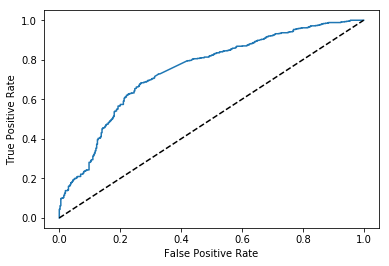

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

paramGrid = [
    {'C': [10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3], 'penalty': ['l2']},
    {'C': [10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3], 'penalty': ['l1']}
 ]

gridSearch = GridSearchCV(logReg, paramGrid, cv=3, iid=False)
X = [gmean for gmean in featureSetDf['gmean']]
y = [gmean for gmean in featureSetDf['case_reversed']]
gridSearch.fit(X,y)
prob = [x[1] for x in gridSearch.predict_proba(X)]

fpr, tpr, thresholds = roc_curve(y, prob)

print("best parameters: (C: {}, penalty: {})\n\n"
      .format(gridSearch.best_params_['C'], gridSearch.best_params_['penalty']))
print("auc: {}".format(roc_auc_score(y, prob)))

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

del X, y, prob, fpr, tpr, thresholds

In [7]:
del featureSetDf

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

sentencesFiltered = []
sentencesText = []

for doc in docs:
    for sentence in doc.sents:
        sentencesFiltered.append(' '.join([token.lemma_ for token in sentence if not token.is_stop]))
        sentencesText.append(sentence.text)

scores = [analyser.polarity_scores(sentence)['compound'] for sentence in sentencesText]

sentenceDf = pd.DataFrame({'sentenceFiltered': sentencesFiltered, 'score': scores, 'sentenceText': sentencesText})

print("most positive sentences:\n")

for index, entry in sentenceDf.nlargest(10, 'score').iterrows():
    print("sentence: (score: {})\n{}\n".format(entry['score'], entry['sentenceText']))

print("\nmost negative sentences:\n")
    
for index, entry in sentenceDf.nsmallest(10, 'score').iterrows():
    print("sentence: (score: {})\n{}\n".format(entry['score'], entry['sentenceText']))

del analyser, sentencesFiltered, scores, sentencesText

most positive sentences:

sentence: (score: 0.9719)
723a ), provides that: "the supreme court of the united states shall have the power to prescribe, from time to time, rules of practice and procedure with respect to any or all proceedings after verdict, or finding of guilt by the court if a jury has been waived, or plea of guilty, in criminal cases in district courts of the united states, including the district courts of alaska, hawaii, puerto rico, canal zone, and virgin islands, in the supreme courts of the district of columbia, hawaii, and puerto rico, in the united states court for china, in the united states circuit courts of appeals, in the united states court of appeals for the district of columbia, and in the supreme court of the united states.


sentence: (score: 0.9623)
and it appearing that this controversy arises out of the sale on or about march 7, 1942, of 250 shares of preferred stock of the higbee company, debtor, in a reorganization proceeding, and ten shares of stock

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentenceDf['sentenceFiltered'])
cos_sim = cosine_similarity(X)

maxValue = 0
minValue = 1
maxIndex = 0
minIndex = 0

i = 0
dim = len(sentenceDf['sentenceFiltered'])
while i < dim:
    j = i + 1
    while j < dim:
        if maxValue < cos_sim[i][j] < 1:
            maxValue = cos_sim[i][j]
            maxIndex = [i,j]
        if minValue > cos_sim[i][j] > 0:
            minValue = cos_sim[i][j]
            minIndex = [i,j]
        j += 1
    i += 1

    
print("Similarity: {}\n\nSentence 1:\n{}\n\nSentence 2:\n{}\n\n"
      .format(maxValue, sentenceDf.loc[maxIndex[0]]['sentenceText'],sentenceDf.loc[maxIndex[1]]['sentenceText']))
print("Similarity: {}\n\nSentence 1:\n{}\n\nSentence 2:\n{}"
      .format(minValue, sentenceDf.loc[minIndex[0]]['sentenceText'],sentenceDf.loc[minIndex[1]]['sentenceText']))

del maxValue, maxIndex, minValue, minIndex, dim, vectorizer, cos_sim, i

Similarity: 0.9999999999999999

Sentence 1:
48 f.(2d)

Sentence 2:
48 f.(2d)


Similarity: 0.000999362153300812

Sentence 1:
and it appearing that this controversy arises out of the sale on or about march 7, 1942, of 250 shares of preferred stock of the higbee company, debtor, in a reorganization proceeding, and ten shares of stock in the same company owned by j. f. potts and william w. boag respectively, to c. l. bradley and j. p. murphy, for a total consideration of $115,000, an amount far in excess of the value of the shares; and it appearing that potts and boag at the time of the sale were prosecuting an appeal from the order of the united states district court for the northern district of ohio, eastern division, confirming the amended plan of reorganization of the debtor, which was dismissed march 11, 1942; and it appearing that the amended application of appellant for institution of proceedings filed herein prays that an order be entered either (1) authorizing him to employ couns

In [10]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=20,n_jobs=-1)
km.fit(X)
docClusters = km.labels_.tolist()

clusters = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
i = 0
while i < len(docClusters):
    clusters[docClusters[i]].append(i)
    i += 1

i = 0
while i < len(clusters):
    j = 0
    print('Cluster #{}:\n'.format((i + 1)))
    while j < min(5,len(clusters[i])):
        print("Sample #{}:\n{}".format((j + 1), sentenceDf.loc[clusters[i][j]]['sentenceText']))
        j += 1
    i += 1
    print('\n\n')
    
del docClusters, km, i, clusters

Cluster #1:

Sample #1:
we reverse and remand.

Sample #2:
we therefore reverse his conviction and remand so that he can plead anew.
reversed and remanded for further proceedings.

Sample #3:
accordingly, we reverse the judgment of the district court enjoining appellant's strike and remand the case for further proceedings.

Sample #4:
the judgment of the district court is reversed and judgment is here rendered in favor of the mutual life insurance company of new york.

Sample #5:
reversed and rendered.




Cluster #2:

Sample #1:
discussion the government argues and the district court found that hyde did not offer a "fair and just reason" to withdraw his plea.

Sample #2:
following a bench trial, the district court found that laidlaw had committed numerous permit violations and imposed a penalty of $405,800.

Sample #3:
however, because the court found that laidlaw's violations had not harmed the environment and that laidlaw had been in substantial compliance for several years at the t

In [11]:
del sentenceDf, X